In [6]:
from pathlib import Path
import urllib.request
import tarfile
target_folder = Path("/content/drive/MyDrive/Dog_Classifier/Dataset")
target_folder.mkdir(parents=True, exist_ok=True)
tar_path = target_folder / "images.tar"
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
if not tar_path.exists():
    print("Downloading...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download completed.")
print("Extracting...")
with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=target_folder)
print("Extraction completed.")


Downloading...
Download completed.
Extracting...
Extraction completed.


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Dog_Classifier/Dataset/Images"
IMG_SIZE = (331, 331)
BATCH_SIZE = 64

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = train_generator.num_classes
print("Number of classes:", NUM_CLASSES)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Number of classes: 120


In [ ]:
base_model = NASNetLarge(
    include_top=False,
    weights='imagenet',
    input_shape=(331, 331, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 331, 331,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 165, 165,  │      2,592 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 165, 165,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 165, 165,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 165, 165,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 165, 165,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 169, 169,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 171, 171,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 83, 83,    │      2,814 │ activation_2[0][

 Total params: 85,400,778 (325.78 MB)

 Trainable params: 10,538,424 (40.20 MB)

 Non-trainable params: 74,862,354 (285.58 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath='/content/drive/MyDrive/Dog_Classifier/Models/nasnet_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=300,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7520 - loss: 1.8008 
Epoch 1: val_accuracy improved from -inf to 0.92559, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 4556s 17s/step - accuracy: 0.7524 - loss: 1.7968 - val_accuracy: 0.9256 - val_loss: 0.2597 - learning_rate: 1.0000e-04
Epoch 2/300
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9371 - loss: 0.1996
Epoch 2: val_accuracy improved from 0.92559 to 0.93099, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_best_model.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.9371 - loss: 0.1996 - val_accuracy: 0.9310 - val_loss: 0.2629 - learning_rate: 1.0000e-04
Epoch 3/300
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9492 - loss: 0.1556
Epoch 3: val_accuracy did not improve from 0.93099
258/258 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.9491 - loss: 0.1556 - val_accuracy: 0.9229 - val_loss: 0.2705 - learning_rate: 1.0000e-04
Epoch 4/300
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9547 - loss: 0.1331
Epoch 4: val_accuracy did not improve from 0.93099

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
258/258 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.9547 - loss: 0.1331 - val_accuracy: 0.9236 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 5/300
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9678 - loss: 0.1015
Epoch 5: val_accuracy did not improve from 0.93099
258/258 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.9678 - loss: 0.101

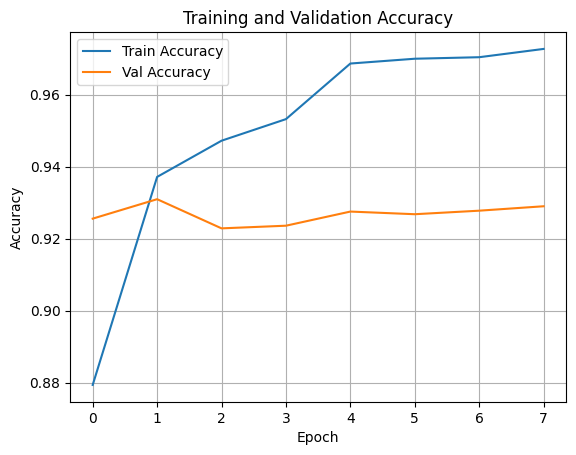

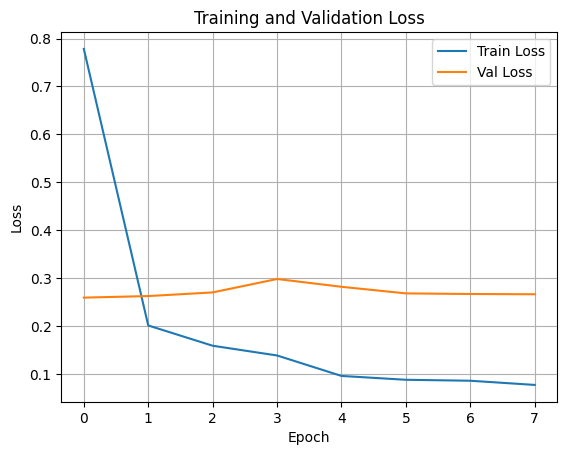

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
from pathlib import Path
temp_path=Path("/content/drive/MyDrive/Dog_Classifier/Dataset/Images")
l = list(temp_path.glob("*"))

In [ ]:
l

[PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02085620-Chihuahua'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02085936-Maltese_dog'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086079-Pekinese'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086240-Shih-Tzu'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088094-Afghan_hound'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088238-basset'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088364-beagle'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088632-bluetick'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02089078-black-and-tan_coonhound'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02089867-Walker_hound'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02090379-redbone'),
 PosixPath('/content/

In [ ]:
dog=[x.stem for x in l]

In [ ]:
from natsort import natsorted
dogsorted=natsorted(dog)

In [ ]:
dogsorted

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi